## RQ1. Do different AI coding agents get used in different types of repositories? 
### We compare repositories with different popularity and activity.

### STEP 1: Load AIDev Dataset from HuggingFace

In [21]:
# Import necessary libraries
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [22]:
# Load pull request data from Hugging Face
pr = pd.read_parquet("hf://datasets/hao-li/AIDev/all_pull_request.parquet")

# Load repository data from Hugging Face
repo = pd.read_parquet("hf://datasets/hao-li/AIDev/all_repository.parquet")

# Load user data from Hugging Face (not used in this script, but loaded for completeness)
user = pd.read_parquet("hf://datasets/hao-li/AIDev/all_user.parquet")

In [23]:
# Display columns for reference
pr.columns

Index(['id', 'number', 'title', 'body', 'agent', 'user_id', 'user', 'state',
       'created_at', 'closed_at', 'merged_at', 'repo_id', 'repo_url',
       'html_url'],
      dtype='object')

In [24]:
# Display columns for reference
repo.columns

Index(['id', 'url', 'license', 'full_name', 'language', 'forks', 'stars'], dtype='object')

In [25]:
# Display columns for reference
user.columns

Index(['id', 'login', 'followers', 'following', 'created_at'], dtype='object')

### Step 2: Filter to AI-generated pull requests

In [26]:
df = pr.copy()

# Keep PRs that have a non-null agent label (AI-generated)
df = df[df["agent"].notna()]

# Keep only PRs with a final state
df = df[df["state"].isin(["merged", "closed"])]

# Parse timestamps
df["created_at"] = pd.to_datetime(df["created_at"], errors="coerce")

### Step 3: Merge repository metadata

In [27]:
# pr.repo_id  ↔  repo.id
df = df.merge(
    repo,
    left_on="repo_id",
    right_on="id",
    how="left",
    suffixes=("_pr", "_repo")
)

### Step 4: Define repository groups

In [28]:
# 4.1 Popularity groups based on star ranking

df["stars"] = df["stars"].fillna(0).astype(float)

# Rank by stars (1 = lowest, N = highest), break ties by order of appearance
df["star_rank"] = df["stars"].rank(method="first")

df["pop_group"] = pd.qcut(
    df["star_rank"],
    q=3,
    labels=["Low", "Medium", "High"]
)

In [29]:
# 4.2 Activity groups based on fork ranking
df["forks"] = df["forks"].fillna(0).astype(float)

# Use forks as a proxy for repository activity
df["fork_rank"] = df["forks"].rank(method="first")

df["activity_group"] = pd.qcut(
    df["fork_rank"],
    q=3,
    labels=["Low", "Medium", "High"]
)

### Step 5: Compute agent distributions

In [30]:
# 5.1 Popularity × Agent
pop_agent = (
    df.groupby(["pop_group", "agent"], observed=False)   
      .size()                                           
      .reset_index(name="count")
)

pop_agent["pct"] = (
    pop_agent.groupby("pop_group", observed=False)["count"]
             .transform(lambda x: x / x.sum())
)

In [31]:
pop_agent

,pop_group,agent,count,pct
0,Low,Claude_Code,2247,0.007839
1,Low,Copilot,24193,0.084401
2,Low,Cursor,0,0.000000
3,Low,Devin,0,0.000000
4,Low,OpenAI_Codex,260202,0.907760
5,Medium,Claude_Code,0,0.000000
6,Medium,Copilot,0,0.000000
7,Medium,Cursor,0,0.000000
8,Medium,Devin,0,0.000000
9,Medium,OpenAI_Codex,286642,1.000000


In [32]:
# 5.2 Activity × Agent
act_agent = (
    df.groupby(["activity_group", "agent"], observed=False)
      .size()
      .reset_index(name="count")
)

act_agent["pct"] = (
    act_agent.groupby("activity_group", observed=False)["count"]
             .transform(lambda x: x / x.sum())
)

In [33]:
act_agent

,activity_group,agent,count,pct
0,Low,Claude_Code,3034,0.010585
1,Low,Copilot,29414,0.102616
2,Low,Cursor,0,0.000000
3,Low,Devin,0,0.000000
4,Low,OpenAI_Codex,254194,0.886800
5,Medium,Claude_Code,0,0.000000
6,Medium,Copilot,0,0.000000
7,Medium,Cursor,0,0.000000
8,Medium,Devin,0,0.000000
9,Medium,OpenAI_Codex,286642,1.000000


### Step 6: Draw graph

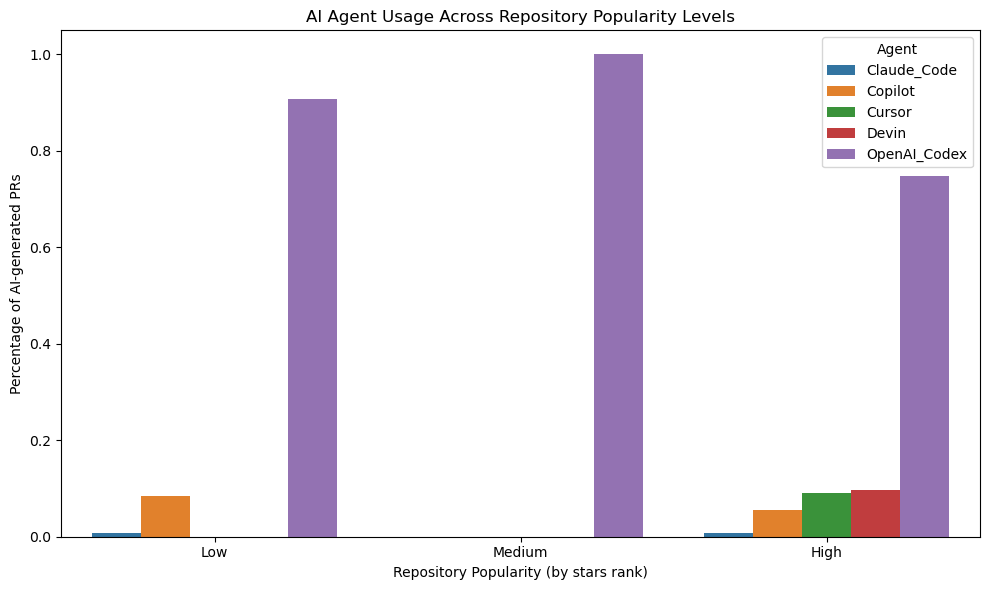

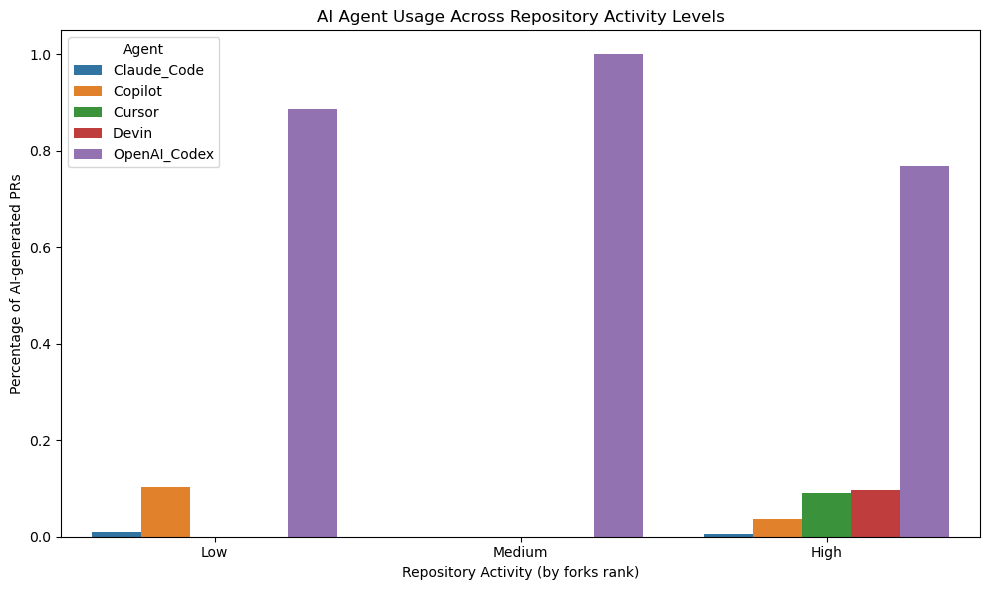

In [34]:
import seaborn as sns
import matplotlib.pyplot as plt

# Popularity vs Agent
plt.figure(figsize=(10, 6))
sns.barplot(
    data=pop_agent,
    x="pop_group",
    y="pct",
    hue="agent"
)
plt.title("AI Agent Usage Across Repository Popularity Levels")
plt.xlabel("Repository Popularity (by stars rank)")
plt.ylabel("Percentage of AI-generated PRs")
plt.legend(title="Agent")
plt.tight_layout()
plt.show()

# Activity vs Agent
plt.figure(figsize=(10, 6))
sns.barplot(
    data=act_agent,
    x="activity_group",
    y="pct",
    hue="agent"
)
plt.title("AI Agent Usage Across Repository Activity Levels")
plt.xlabel("Repository Activity (by forks rank)")
plt.ylabel("Percentage of AI-generated PRs")
plt.legend(title="Agent")
plt.tight_layout()
plt.show()